# Hidden Markov Models: Bayesian Smoothing

In this notebook, we overview and express the process of Bayesian smoothing. Effectively, this will calculate the contirion parobability

$$ P(x_k | y^N) $$

which is the conditional probability that at time $k$, the hidden state of the HMM is $x$ given the *entire* trajectory of observations (past and future) $y^N$. While (much like the backward algoithm) the process of Bayesian smoothing has little utility in the online estimation of the current state of an HMM, but it does play a key role in the inferrence of model parameters (as we will see), as well as the *ex post* determination of the hidden state.

Mathematically, we can determine the Bayesian smoothed estimate of the hidden state of an HMM recursively through the formula

$$ P(x_k | y^N) = P(x_k | y^k) \sum_{x_{k+1}} \frac{P(x_{k+1} | x_k)P(x_{k+1}|y^N)}{P(x_{k+1}| y^k)} $$

To evaluate this, we first generate feedforward estimates (using the Bayesian filter) for $P(x_k | y^k)$ and then backpropagate (iterate backwards) the sequence to determin the $P(x_{k+1}| y^N)$ terms in the summand.

Specifically, the $P(x_k | y^k)$ and $P(x_{k+1} | y^{k})$ terms are known from the forward-propagation of the Bayesian filter, while $P(x_{k+1} | x_k)$ is the transition matrix element (also assumed to be known). The only outstanding term is $P(x_{k+1}| y^N)$. However, the final entry of the sequence (when $k+1 = N$) is simply the last output of the Bayesian filter $P(x_{N} | y^N)$, which can be then used to evaluate the smoother for $P(x_{N-1}| y^{N})$. In turn, this result is used in the next iteration of the algorithm, propagating the probability back to $k=0$, and resulting in the complete filtered time series.

In [1]:
# As with the previous notebook, we first use the dynamics library to generate a simulated path of an HMM

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")
import seaborn as sns

from hidden import dynamics

a = 0.9
b = 0.7

A = np.array([[a, 1 - a], [1 - a, a]])
B = np.array([[b, 1 - b], [1 - b, b]])

hmm = dynamics.HMM(2, 2)

In [3]:
# Initialize the Dynamics and Observation matrices
hmm.initialize_dynamics(A, B)

# Now run the dynamics for 100 steps
hmm.run_dynamics(100)
state_ts = hmm.get_state_ts()
obs_ts = hmm.get_obs_ts()

In [5]:
# Now to calcualte the Bayesian smoothed estimate, we first need to generate
# the Bayesian filter estimate (forward algorithm)

filter_tracker = []
filter_estimate = np.array([0.5, 0.5])
p1_tracker = []

def bayesian_filter(hmm, bayes_est, obs):
    bayes_est = hmm.A @ bayes_est
    bayes_est = hmm.B[:, obs] * bayes_est
    bayes_est = bayes_est / np.sum(bayes_est)

    return bayes_est

for o in obs_ts:
    filter_estimate = bayesian_filter(hmm, filter_estimate, o)
    filter_tracker.append(filter_estimate)
    p1_tracker.append(filter_estimate[1])


In [6]:
# Now to calcualte the smoothed estiamte, we backpropagate the results from the
# forward algorithm as

bayesian_smoother = [[]]*len(filter_tracker)
bayesian_smoother[-1] = np.array(filter_tracker[-1])

for i in range(len(filter_tracker) - 1):
    # First, calculate the 'predction' step of the Bayesian filter
    # This calaculates P(x_{k+1} | y^k) (for k = -(i+2))
    bayes_predict = np.matmul(A, filter_tracker[-(i + 2)])
    # Numerator in smoother will be element-wise product of next prediction
    # and corresponding column of A matrix
    summand = [np.sum(bayesian_smoother[-(i + 1)] * A[:, j] / bayes_predict) for j in range(A.shape[1])]
    bayesian_smoother[-(i + 2)] = filter_tracker[-(i + 2)] * np.array(summand)


In [11]:
# First we can build the analog of the 'p1_tracker' for the Bayesian smoothed
# array

p1_smooth = [s[1] for s in bayesian_smoother]

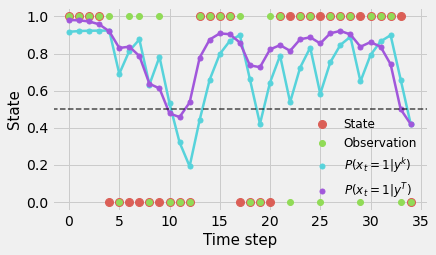

In [13]:
# Now, we can plot hte trajectory, filter and smoother to compare the results

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette("hls", 4)

ax.plot(state_ts[-35:], 'o', color=Pal[0], markersize=8, label="State")
ax.plot(obs_ts[-35:], 'o', color=Pal[1], markersize=6, label="Observation")
ax.plot(p1_tracker[-35:], linewidth=2.5, color=Pal[2])
ax.plot(p1_tracker[-35:], 'o', markersize=5, color=Pal[2], label=r"$P(x_t = 1|y^k)$")

ax.plot(p1_smooth[-35:], linewidth=2.5, color=Pal[3])
ax.plot(p1_smooth[-35:], 'o', markersize=5, color=Pal[3], label=r"$P(x_t = 1| y^T)$")


ax.axhline(0.5, linestyle='--', color='k', linewidth=1.5, alpha=0.7)

ax.set_xlabel(r"Time step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, frameon=False)